# Performance Testing Analysis

This notebook analyzes existing performance test results from the `results` directory, providing comprehensive statistical analysis and visualizations of web application performance metrics.

## Overview
- **Data Loading**: Loads performance test results from CSV files in the results directory
- **Statistical Analysis**: Comprehensive analysis of page load times and API response times
- **Data Visualization**: Charts and graphs showing performance patterns and trends
- **Report Generation**: Detailed performance insights and recommendations
- **Multiple Iteration Analysis**: Statistical analysis of test reliability and consistency

## 1. Environment Setup and Dependencies

In [2]:
# Import required libraries for testing, data analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import glob
import asyncio
import time
import requests
from playwright.async_api import async_playwright
import warnings

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ All dependencies imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📈 Seaborn version: {sns.__version__}")
print(f"🎭 Playwright available for browser automation")

✅ All dependencies imported successfully!
📊 Pandas version: 2.1.4
📈 Seaborn version: 0.12.2
🎭 Playwright available for browser automation


## 2. Data Loading Configuration

In [3]:
# Configuration for data analysis
RESULTS_DIR = "results"

# Ensure results directory exists and check for data files
if not os.path.exists(RESULTS_DIR):
    print(f"❌ Results directory '{RESULTS_DIR}' not found!")
    print("Please make sure you have performance test results in the results folder.")
else:
    print(f"✅ Results directory found: {RESULTS_DIR}")
    
    # List available CSV files
    csv_files = glob.glob(os.path.join(RESULTS_DIR, "*.csv"))
    
    if not csv_files:
        print("⚠️ No CSV files found in results directory")
    else:
        print(f"📂 Found {len(csv_files)} CSV file(s):")
        for file in csv_files:
            filename = os.path.basename(file)
            file_size = os.path.getsize(file) / 1024  # KB
            print(f"  • {filename} ({file_size:.1f} KB)")

# Helper function to identify the best CSV file to analyze
def get_best_csv_file():
    """Get the most appropriate CSV file for analysis"""
    csv_files = glob.glob(os.path.join(RESULTS_DIR, "*.csv"))
    
    if not csv_files:
        return None
    
    # Prefer files with "iterations" in the name for comprehensive analysis
    iteration_files = [f for f in csv_files if "iterations" in f.lower()]
    if iteration_files:
        # Get the most recent iteration file
        return max(iteration_files, key=os.path.getctime)
    
    # Otherwise, get the most recent file
    return max(csv_files, key=os.path.getctime)

# Identify the primary file for analysis
primary_csv = get_best_csv_file()
if primary_csv:
    print(f"\n🎯 Primary analysis file: {os.path.basename(primary_csv)}")
else:
    print(f"\n❌ No suitable CSV files found for analysis")

✅ Results directory found: results
📂 Found 2 CSV file(s):
  • performance_test_results_30iterations_20251129_152730.csv (38.1 KB)
  • quick_test_results_20251129_150910.csv (3.0 KB)

🎯 Primary analysis file: performance_test_results_30iterations_20251129_152730.csv


## 3. Load and Examine Test Results Data

In [4]:
def load_performance_data(csv_file_path):
    """Load and examine performance test data from CSV file"""
    
    if not csv_file_path or not os.path.exists(csv_file_path):
        print("❌ CSV file not found or not specified")
        return None
    
    try:
        # Load the CSV data
        df = pd.read_csv(csv_file_path)
        filename = os.path.basename(csv_file_path)
        
        print(f"📂 Successfully loaded: {filename}")
        print(f"📊 Total records: {len(df)}")
        
        # Display basic info about the dataset
        print(f"\n🔍 Dataset Overview:")
        print(f"  • Shape: {df.shape[0]} rows × {df.shape[1]} columns")
        print(f"  • Columns: {list(df.columns)}")
        
        # Check for multiple iterations
        if 'Iteration' in df.columns:
            iterations = df['Iteration'].unique()
            print(f"  • Iterations: {len(iterations)} ({min(iterations)} to {max(iterations)})")
        
        # Check test types
        if 'Type' in df.columns:
            test_types = df['Type'].value_counts()
            print(f"  • Test Types: {dict(test_types)}")
        
        # Check for different column name patterns
        time_column = None
        possible_time_columns = ['Load Time/Response Time (ms)', 'Load Time (ms)', 'Response Time (ms)']
        for col in possible_time_columns:
            if col in df.columns:
                time_column = col
                break
        
        if time_column:
            print(f"  • Time column: '{time_column}'")
            
            # Basic statistics on performance times
            valid_times = df[df[time_column] > 0][time_column]
            if len(valid_times) > 0:
                print(f"  • Valid measurements: {len(valid_times)} out of {len(df)}")
                print(f"  • Time range: {valid_times.min():.1f}ms to {valid_times.max():.1f}ms")
                print(f"  • Average time: {valid_times.mean():.1f}ms")
        
        # Display sample data
        print(f"\n📋 Sample Data (first 5 rows):")
        print(df.head())
        
        return df
    
    except Exception as e:
        print(f"❌ Error loading CSV file: {e}")
        return None

# Load the primary dataset
if primary_csv:
    df_raw = load_performance_data(primary_csv)
else:
    df_raw = None
    print("⚠️ No CSV file available for analysis")

📂 Successfully loaded: performance_test_results_30iterations_20251129_152730.csv
📊 Total records: 570

🔍 Dataset Overview:
  • Shape: 570 rows × 7 columns
  • Columns: ['Type', 'Name', 'Load Time (ms)', 'Size (KB)', 'Status', 'Iteration', 'Timestamp']
  • Iterations: 30 (1 to 30)
  • Test Types: {'API': 300, 'Page': 270}
  • Time column: 'Load Time (ms)'
  • Valid measurements: 570 out of 570
  • Time range: 59.1ms to 1192.7ms
  • Average time: 454.1ms

📋 Sample Data (first 5 rows):
   Type                                  Name  Load Time (ms)  Size (KB) Status  Iteration                   Timestamp
0  Page                            Login Page          605.50      12.31     OK          1  2025-11-29T15:16:39.400342
1  Page                 Dashboard Admin Pusat          631.83      12.41     OK          1  2025-11-29T15:16:40.533203
2  Page                   Daftar Item (Table)          617.56      12.95     OK          1  2025-11-29T15:16:41.661548
3  Page                       QR Sca

## 4. Data Cleaning and Preparation

In [5]:
def clean_and_prepare_data(df_raw):
    """Clean and prepare the performance data for analysis"""
    
    if df_raw is None or len(df_raw) == 0:
        print("❌ No data to clean")
        return None, None, None
    
    print("🧹 Cleaning and preparing data...")
    
    # Make a copy to avoid modifying original data
    df = df_raw.copy()
    
    # Standardize column names - handle different possible column name formats
    column_mapping = {}
    
    # Map time column to standard name
    time_columns = ['Load Time/Response Time (ms)', 'Load Time (ms)', 'Response Time (ms)']
    for col in time_columns:
        if col in df.columns:
            column_mapping[col] = 'Time_ms'
            break
    
    # Map other common column variations
    if 'Path/Endpoint' in df.columns:
        column_mapping['Path/Endpoint'] = 'Endpoint'
    elif 'Endpoint' in df.columns:
        column_mapping['Endpoint'] = 'Endpoint'
        
    if 'Size (KB)' in df.columns:
        column_mapping['Size (KB)'] = 'Size_KB'
        
    # Apply column mapping
    if column_mapping:
        df = df.rename(columns=column_mapping)
        print(f"  • Standardized column names: {list(column_mapping.values())}")
    
    # Filter out invalid measurements
    if 'Time_ms' in df.columns:
        initial_count = len(df)
        df_clean = df[df['Time_ms'] > 0].copy()
        filtered_count = len(df_clean)
        
        print(f"  • Removed {initial_count - filtered_count} invalid measurements")
        print(f"  • Clean dataset: {filtered_count} valid measurements")
    else:
        print("⚠️ No time column found - using all data")
        df_clean = df.copy()
    
    # Separate by test type if available
    df_pages = pd.DataFrame()
    df_apis = pd.DataFrame()
    
    if 'Type' in df_clean.columns:
        df_pages = df_clean[df_clean['Type'] == 'Page'].copy()
        df_apis = df_clean[df_clean['Type'] == 'API'].copy()
        
        print(f"  • Page tests: {len(df_pages)}")
        print(f"  • API tests: {len(df_apis)}")
    else:
        print("  • No type column found - treating all as general performance tests")
    
    # Add derived metrics if possible
    if 'Time_ms' in df_clean.columns:
        # Performance categories
        df_clean['Performance_Category'] = pd.cut(
            df_clean['Time_ms'], 
            bins=[0, 100, 500, 1000, float('inf')], 
            labels=['Excellent', 'Good', 'Fair', 'Poor']
        )
        
        print(f"  • Added performance categories")
        
        # Display category distribution
        category_counts = df_clean['Performance_Category'].value_counts()
        print(f"  • Category distribution:")
        for category, count in category_counts.items():
            percentage = (count / len(df_clean)) * 100
            print(f"    - {category}: {count} ({percentage:.1f}%)")
    
    return df_clean, df_pages, df_apis

# Clean and prepare the data
if df_raw is not None:
    df_clean, df_pages, df_apis = clean_and_prepare_data(df_raw)
    
    if df_clean is not None:
        print(f"\n✅ Data preparation complete!")
        print(f"📊 Ready for analysis with {len(df_clean)} clean measurements")
    else:
        print("❌ Data preparation failed")
else:
    print("⚠️ No raw data available for cleaning")

🧹 Cleaning and preparing data...
  • Standardized column names: ['Time_ms', 'Size_KB']
  • Removed 0 invalid measurements
  • Clean dataset: 570 valid measurements
  • Page tests: 270
  • API tests: 300
  • Added performance categories
  • Category distribution:
    - Fair: 296 (51.9%)
    - Good: 259 (45.4%)
    - Excellent: 9 (1.6%)
    - Poor: 6 (1.1%)

✅ Data preparation complete!
📊 Ready for analysis with 570 clean measurements


## 5. Basic Statistical Analysis

In [7]:
def perform_statistical_analysis(df_clean, df_pages, df_apis):
    """Perform comprehensive statistical analysis on the performance data"""
    
    if df_clean is None or len(df_clean) == 0:
        print("❌ No clean data available for statistical analysis")
        return
    
    print("📈 Performing Statistical Analysis")
    print("=" * 50)
    
    # Overall Performance Statistics
    if 'Time_ms' in df_clean.columns:
        print("🌟 OVERALL PERFORMANCE STATISTICS")
        print("-" * 40)
        
        overall_stats = df_clean['Time_ms'].describe()
        print(f"Total Measurements: {len(df_clean)}")
        print(f"Mean Response Time: {overall_stats['mean']:.2f} ms")
        print(f"Median Response Time: {overall_stats['50%']:.2f} ms")
        print(f"Standard Deviation: {overall_stats['std']:.2f} ms")
        print(f"Minimum Time: {overall_stats['min']:.2f} ms")
        print(f"Maximum Time: {overall_stats['max']:.2f} ms")
        print(f"95th Percentile: {np.percentile(df_clean['Time_ms'], 95):.2f} ms")
        print(f"99th Percentile: {np.percentile(df_clean['Time_ms'], 99):.2f} ms")
        
        # Coefficient of Variation (measure of relative variability)
        cv = (overall_stats['std'] / overall_stats['mean']) * 100
        print(f"Coefficient of Variation: {cv:.1f}% ({'Low variability' if cv < 20 else 'Medium variability' if cv < 50 else 'High variability'})")
    
    # Page Performance Analysis
    if len(df_pages) > 0 and 'Time_ms' in df_pages.columns:
        print(f"\n🌐 PAGE PERFORMANCE ANALYSIS")
        print("-" * 40)
        
        page_stats = df_pages['Time_ms'].describe()
        print(f"Page Tests: {len(df_pages)}")
        print(f"Average Page Load Time: {page_stats['mean']:.2f} ms")
        print(f"Median Page Load Time: {page_stats['50%']:.2f} ms")
        print(f"Page Load Std Dev: {page_stats['std']:.2f} ms")
        print(f"Fastest Page Load: {page_stats['min']:.2f} ms")
        print(f"Slowest Page Load: {page_stats['max']:.2f} ms")
        
        # Top and bottom performers
        if 'Name' in df_pages.columns:
            # Group by page name for multi-iteration data
            if 'Iteration' in df_pages.columns:
                page_summary = df_pages.groupby('Name')['Time_ms'].agg(['mean', 'std', 'count']).sort_values('mean')
                print(f"\n🏆 BEST PERFORMING PAGES (Average Load Time):")
                for name, row in page_summary.head(3).iterrows():
                    print(f"  • {name}: {row['mean']:.1f}ms (±{row['std']:.1f}ms, n={row['count']})")
                
                print(f"\n⚠️  SLOWEST PERFORMING PAGES:")
                for name, row in page_summary.tail(3).iterrows():
                    print(f"  • {name}: {row['mean']:.1f}ms (±{row['std']:.1f}ms, n={row['count']})")
            else:
                fastest_pages = df_pages.nsmallest(3, 'Time_ms')[['Name', 'Time_ms']]
                slowest_pages = df_pages.nlargest(3, 'Time_ms')[['Name', 'Time_ms']]
                
                print(f"\n🏆 FASTEST PAGES:")
                for _, row in fastest_pages.iterrows():
                    print(f"  • {row['Name']}: {row['Time_ms']:.1f}ms")
                
                print(f"\n⚠️  SLOWEST PAGES:")
                for _, row in slowest_pages.iterrows():
                    print(f"  • {row['Name']}: {row['Time_ms']:.1f}ms")
    
    # API Performance Analysis
    if len(df_apis) > 0 and 'Time_ms' in df_apis.columns:
        print(f"\n🚀 API PERFORMANCE ANALYSIS")
        print("-" * 40)
        
        api_stats = df_apis['Time_ms'].describe()
        print(f"API Tests: {len(df_apis)}")
        print(f"Average API Response Time: {api_stats['mean']:.2f} ms")
        print(f"Median API Response Time: {api_stats['50%']:.2f} ms")
        print(f"API Response Std Dev: {api_stats['std']:.2f} ms")
        print(f"Fastest API Response: {api_stats['min']:.2f} ms")
        print(f"Slowest API Response: {api_stats['max']:.2f} ms")
        
        # Top and bottom performers
        if 'Name' in df_apis.columns:
            if 'Iteration' in df_apis.columns:
                api_summary = df_apis.groupby('Name')['Time_ms'].agg(['mean', 'std', 'count']).sort_values('mean')
                print(f"\n🏆 FASTEST APIs (Average Response Time):")
                for name, row in api_summary.head(3).iterrows():
                    print(f"  • {name}: {row['mean']:.1f}ms (±{row['std']:.1f}ms, n={row['count']})")
                
                print(f"\n⚠️  SLOWEST APIs:")
                for name, row in api_summary.tail(3).iterrows():
                    print(f"  • {name}: {row['mean']:.1f}ms (±{row['std']:.1f}ms, n={row['count']})")
            else:
                fastest_apis = df_apis.nsmallest(3, 'Time_ms')[['Name', 'Time_ms']]
                slowest_apis = df_apis.nlargest(3, 'Time_ms')[['Name', 'Time_ms']]
                
                print(f"\n🏆 FASTEST APIs:")
                for _, row in fastest_apis.iterrows():
                    print(f"  • {row['Name']}: {row['Time_ms']:.1f}ms")
                
                print(f"\n⚠️  SLOWEST APIs:")
                for _, row in slowest_apis.iterrows():
                    print(f"  • {row['Name']}: {row['Time_ms']:.1f}ms")
    
    # Performance Category Analysis
    if 'Performance_Category' in df_clean.columns:
        print(f"\n📊 PERFORMANCE CATEGORY BREAKDOWN")
        print("-" * 40)
        
        category_stats = df_clean['Performance_Category'].value_counts()
        total_tests = len(df_clean)
        
        for category in ['Excellent', 'Good', 'Fair', 'Poor']:
            if category in category_stats:
                count = category_stats[category]
                percentage = (count / total_tests) * 100
                print(f"{category:10s}: {count:4d} tests ({percentage:5.1f}%)")
    
    print(f"\n✅ Statistical analysis complete!")

# Perform statistical analysis
if df_clean is not None:
    perform_statistical_analysis(df_clean, df_pages, df_apis)
else:
    print("⚠️ No clean data available for statistical analysis")

📈 Performing Statistical Analysis
🌟 OVERALL PERFORMANCE STATISTICS
----------------------------------------
Total Measurements: 570
Mean Response Time: 454.05 ms
Median Response Time: 542.44 ms
Standard Deviation: 223.74 ms
Minimum Time: 59.08 ms
Maximum Time: 1192.71 ms
95th Percentile: 772.42 ms
99th Percentile: 963.13 ms
Coefficient of Variation: 49.3% (Medium variability)

🌐 PAGE PERFORMANCE ANALYSIS
----------------------------------------
Page Tests: 270
Average Page Load Time: 652.02 ms
Median Page Load Time: 622.85 ms
Page Load Std Dev: 97.84 ms
Fastest Page Load: 555.40 ms
Slowest Page Load: 1192.71 ms

🏆 BEST PERFORMING PAGES (Average Load Time):
  • Login Page: 593.7ms (±24.4ms, n=30.0)
  • QR Scanner Page: 603.3ms (±44.0ms, n=30.0)
  • Halaman Manajemen User (Super Admin): 622.8ms (±21.3ms, n=30.0)

⚠️  SLOWEST PERFORMING PAGES:
  • Daftar Item (Table): 629.8ms (±25.0ms, n=30.0)
  • Dashboard Admin Pusat: 649.5ms (±28.1ms, n=30.0)
  • Halaman Generate QR: 890.1ms (±121.3ms,

## 6. Performance Visualization Dashboard

📊 Creating Performance Visualization Dashboard...


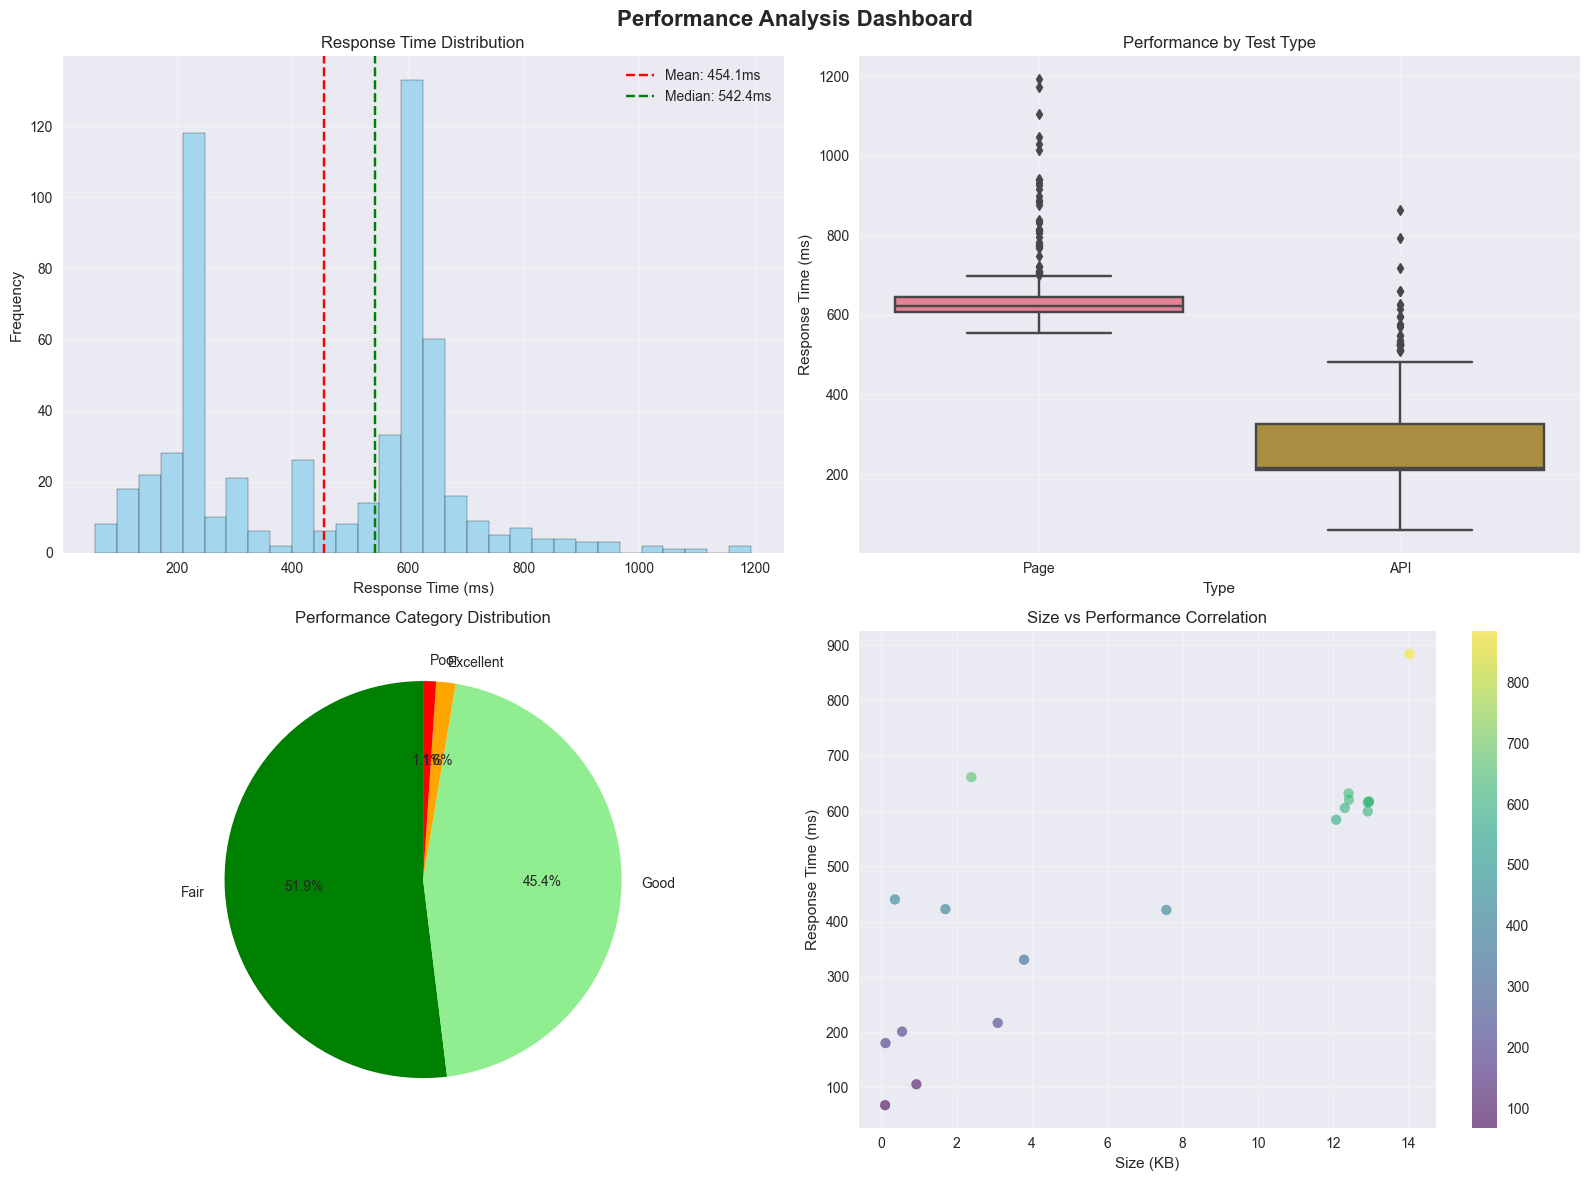

✅ Performance dashboard created successfully!


In [18]:
def create_performance_dashboard(df_clean, df_pages, df_apis):
    """Create a comprehensive performance visualization dashboard"""
    
    if df_clean is None or len(df_clean) == 0:
        print("❌ No data available for visualization")
        return
    
    print("📊 Creating Performance Visualization Dashboard...")
    
    # Determine if we have multi-iteration data
    has_iterations = 'Iteration' in df_clean.columns
    has_time_data = 'Time_ms' in df_clean.columns
    
    if not has_time_data:
        print("⚠️ No time data found - visualization limited")
        return
    
    # Set up the dashboard - 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Overall Performance Distribution
    ax1 = axes[0, 0]
    if has_time_data:
        ax1.hist(df_clean['Time_ms'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.axvline(df_clean['Time_ms'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_clean["Time_ms"].mean():.1f}ms')
        ax1.axvline(df_clean['Time_ms'].median(), color='green', linestyle='--', 
                   label=f'Median: {df_clean["Time_ms"].median():.1f}ms')
        ax1.set_xlabel('Response Time (ms)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Response Time Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # 2. Performance by Test Type (if available)
    ax2 = axes[0, 1]
    if 'Type' in df_clean.columns and len(df_clean['Type'].unique()) > 1:
        sns.boxplot(data=df_clean, x='Type', y='Time_ms', ax=ax2)
        ax2.set_title('Performance by Test Type')
        ax2.set_ylabel('Response Time (ms)')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No test type data\navailable', 
                transform=ax2.transAxes, ha='center', va='center', fontsize=12)
        ax2.set_title('Test Type Comparison')
    
    # 3. Performance Categories Pie Chart
    ax3 = axes[1, 0]
    if 'Performance_Category' in df_clean.columns:
        category_counts = df_clean['Performance_Category'].value_counts()
        colors = ['green', 'lightgreen', 'orange', 'red']
        ax3.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
               colors=colors[:len(category_counts)], startangle=90)
        ax3.set_title('Performance Category Distribution')
    else:
        ax3.text(0.5, 0.5, 'No category data\navailable', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    
    # 4. Top Performers Bar Chart
    ax4 = axes[1, 1]
    if 'Size_KB' in df_clean.columns and df_clean['Size_KB'].sum() > 0:
        valid_size_data = df_clean[df_clean['Size_KB'] > 0]
        if len(valid_size_data) > 0:
            scatter = ax4.scatter(valid_size_data['Size_KB'], valid_size_data['Time_ms'], 
                                alpha=0.6, c=valid_size_data['Time_ms'], cmap='viridis')
            ax4.set_xlabel('Size (KB)')
            ax4.set_ylabel('Response Time (ms)')
            ax4.set_title('Size vs Performance Correlation')
            plt.colorbar(scatter, ax=ax4)
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No valid size data\navailable', 
                    transform=ax4.transAxes, ha='center', va='center', fontsize=12)
    else:
        ax4.text(0.5, 0.5, 'No size data\navailable', 
                transform=ax4.transAxes, ha='center', va='center', fontsize=12)
        ax4.set_title('Size vs Performance')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Performance dashboard created successfully!")

# Create the performance dashboard
if df_clean is not None:
    create_performance_dashboard(df_clean, df_pages, df_apis)
else:
    print("⚠️ No data available for dashboard creation")

## 7. Advanced Multi-Iteration Analysis

🔬 Performing Advanced Multi-Iteration Analysis...
📊 Analysis Results for 19 tests:
------------------------------------------------------------
🌟 OVERALL MULTI-ITERATION STATISTICS:
  • Total unique tests: 19
  • Average iterations per test: 30.0
  • Total measurements: 570
  • Overall mean performance: 454.05 ms
  • Performance variability (avg CV): 17.0%

🔍 RELIABILITY ANALYSIS:
  • High Reliability: 10 tests (52.6%)
  • Medium Reliability: 9 tests (47.4%)

🏆 TOP 5 BEST PERFORMING TESTS (Lowest Mean Time):
  • Login API (Invalid Credentials): 123.2ms (±36.8ms, CV: 29.9%, Medium)
  • Reports API: 210.1ms (±48.3ms, CV: 23.0%, Medium)
  • Recipes API: 222.2ms (±100.4ms, CV: 45.2%, Medium)
  • Register API: 235.5ms (±51.6ms, CV: 21.9%, Medium)
  • Item Types API: 237.0ms (±59.4ms, CV: 25.1%, Medium)

⚠️  TOP 5 WORST PERFORMING TESTS (Highest Mean Time):
  • Halaman Generate QR: 890.1ms (±119.3ms, CV: 13.4%, High)
  • Dashboard Admin Pusat: 649.5ms (±27.6ms, CV: 4.3%, High)
  • Daftar Ite

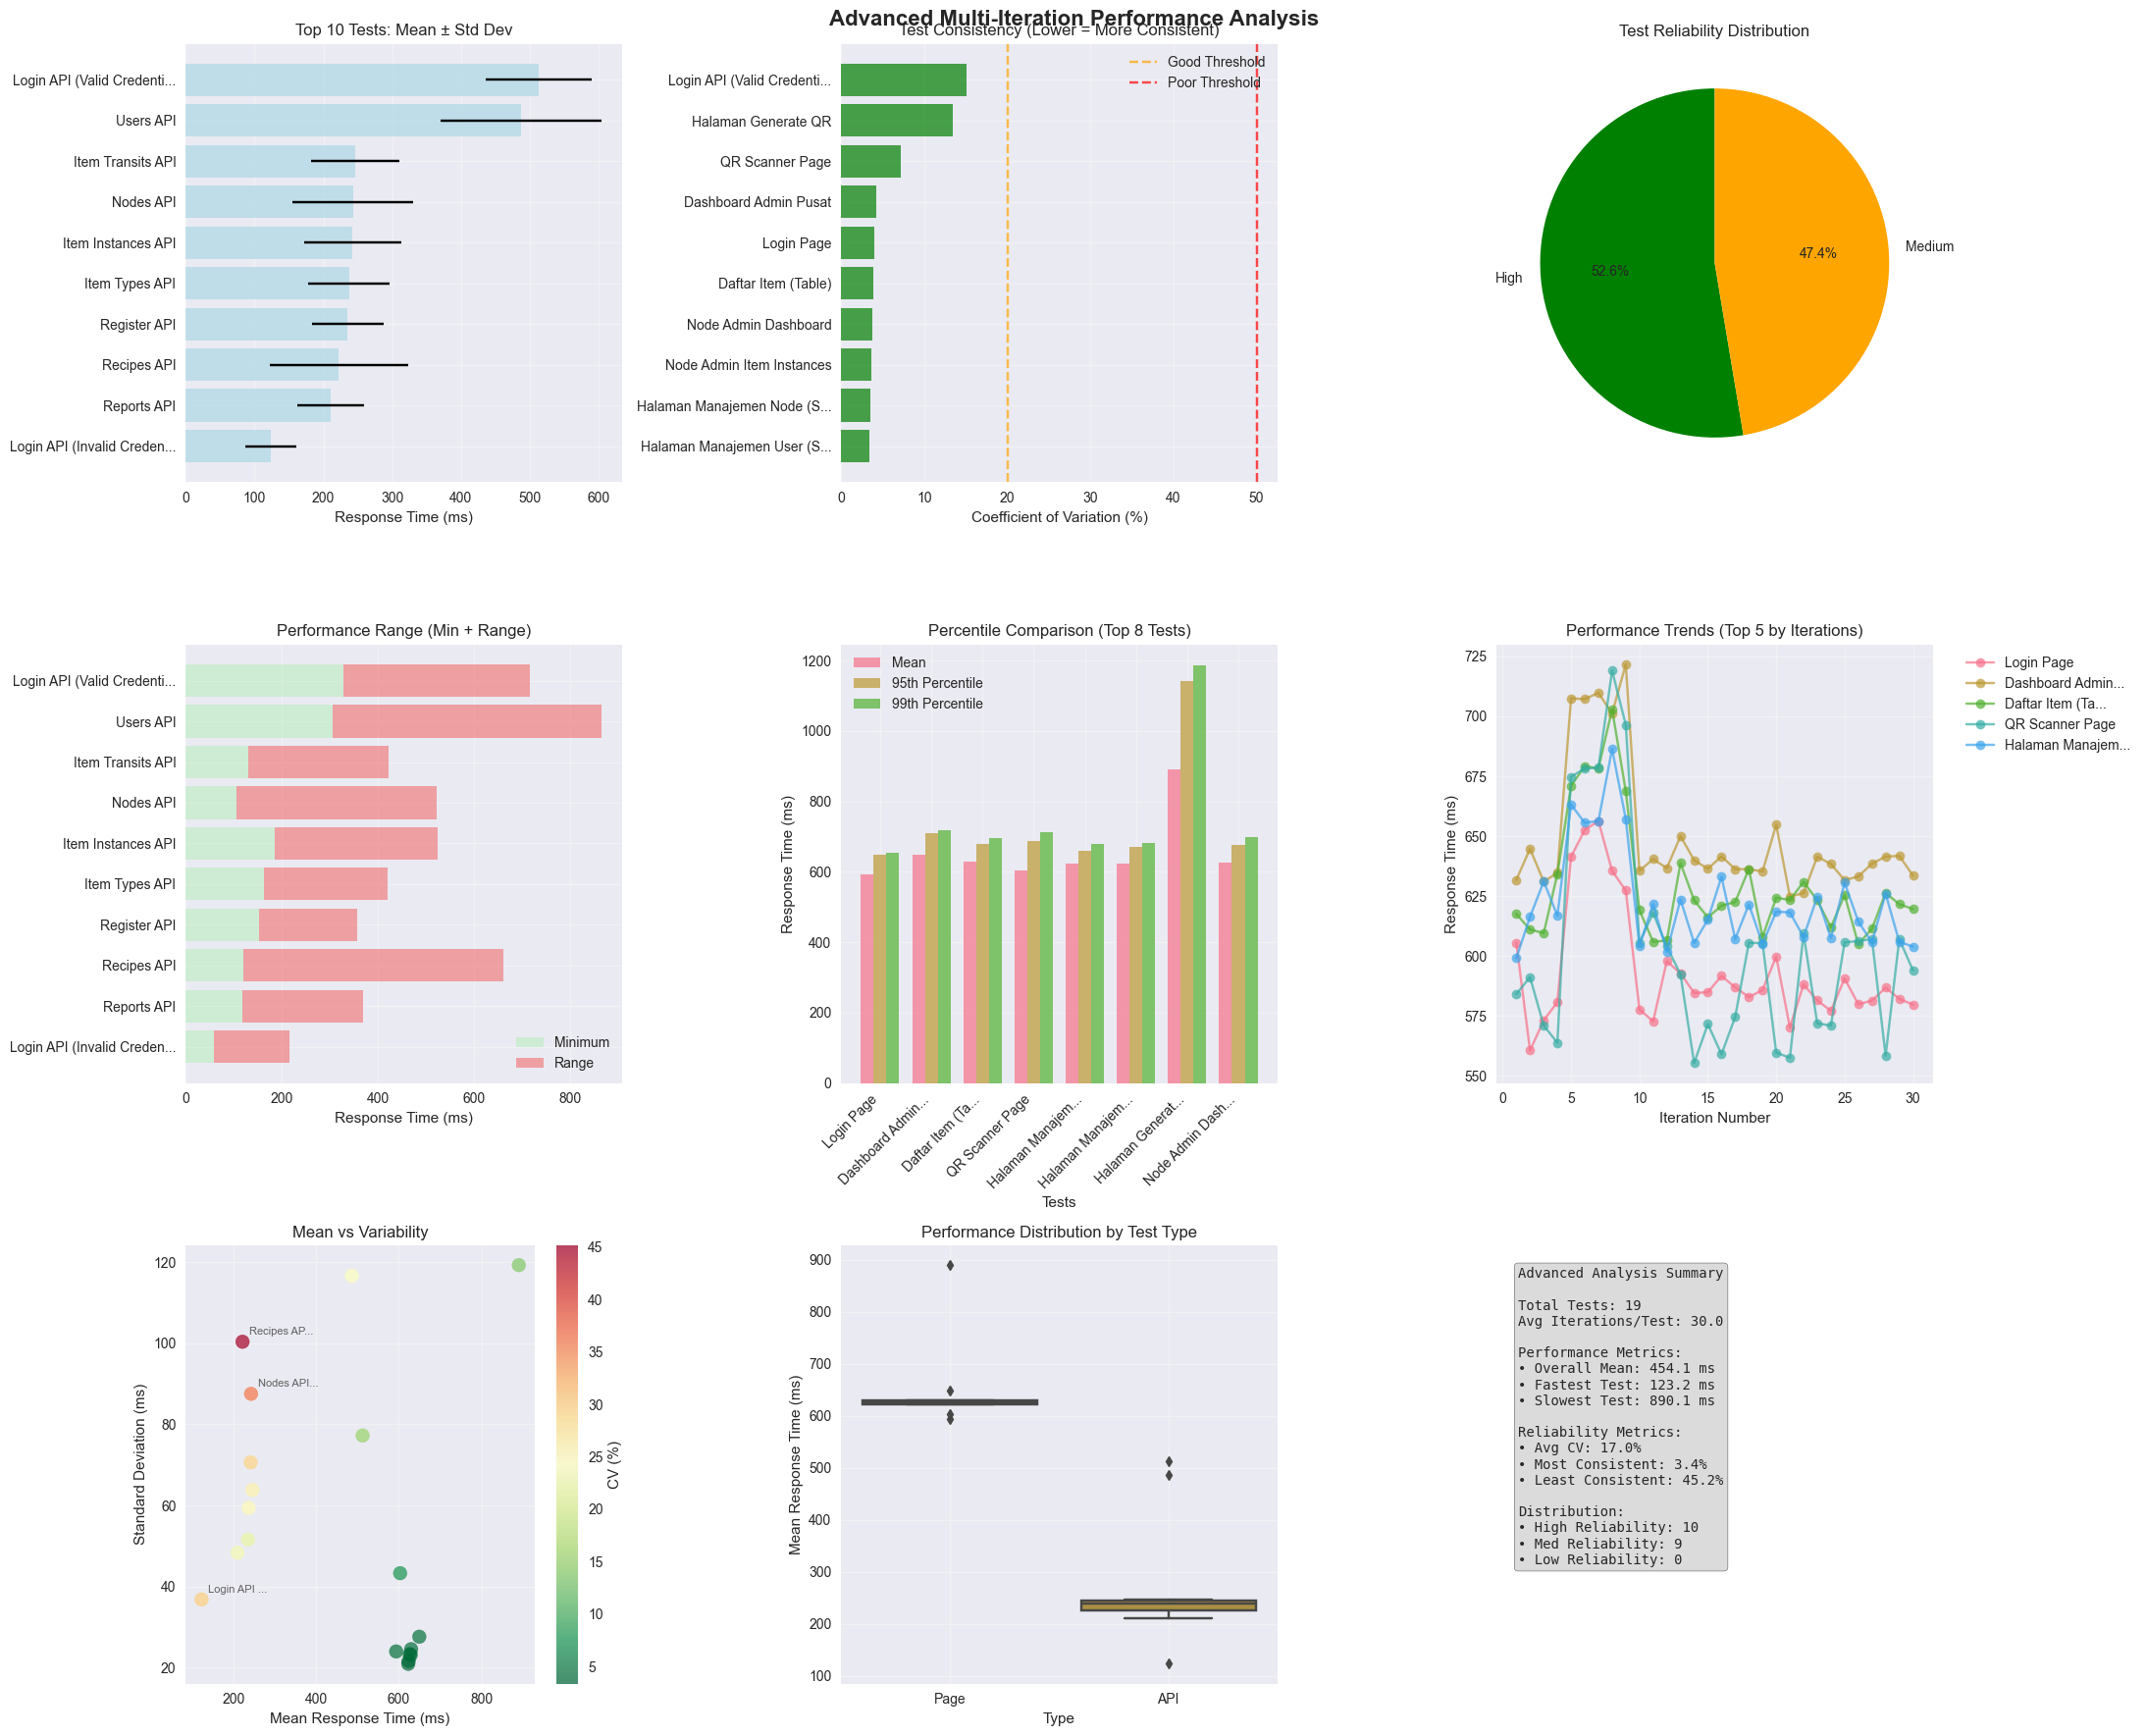

✅ Advanced multi-iteration visualizations created!


In [15]:
def analyze_multiple_iterations_advanced(df_clean):
    """Perform advanced statistical analysis on multi-iteration data"""
    
    if df_clean is None or 'Iteration' not in df_clean.columns:
        print("⚠️ No multi-iteration data available for advanced analysis")
        return None
    
    print("🔬 Performing Advanced Multi-Iteration Analysis...")
    
    # Group by test name to calculate comprehensive statistics
    iteration_stats = []
    
    for test_name in df_clean['Name'].unique():
        test_data = df_clean[df_clean['Name'] == test_name]['Time_ms'].values
        
        if len(test_data) > 1:  # Need multiple measurements for statistics
            stats = {
                'Name': test_name,
                'Type': df_clean[df_clean['Name'] == test_name]['Type'].iloc[0],
                'Iterations': len(test_data),
                'Mean': np.mean(test_data),
                'Median': np.median(test_data),
                'Std_Dev': np.std(test_data),
                'Min': np.min(test_data),
                'Max': np.max(test_data),
                'Range': np.max(test_data) - np.min(test_data),
                'P25': np.percentile(test_data, 25),
                'P75': np.percentile(test_data, 75),
                'P95': np.percentile(test_data, 95),
                'P99': np.percentile(test_data, 99),
                'IQR': np.percentile(test_data, 75) - np.percentile(test_data, 25),
                'CV_Percent': (np.std(test_data) / np.mean(test_data)) * 100,
                'Reliability_Score': 'High' if (np.std(test_data) / np.mean(test_data)) < 0.2 else 
                                   'Medium' if (np.std(test_data) / np.mean(test_data)) < 0.5 else 'Low'
            }
            iteration_stats.append(stats)
    
    if not iteration_stats:
        print("❌ No suitable multi-iteration data found")
        return None
    
    # Convert to DataFrame for easier analysis
    df_stats = pd.DataFrame(iteration_stats)
    
    print(f"📊 Analysis Results for {len(df_stats)} tests:")
    print("-" * 60)
    
    # Overall Statistics
    print("🌟 OVERALL MULTI-ITERATION STATISTICS:")
    print(f"  • Total unique tests: {len(df_stats)}")
    print(f"  • Average iterations per test: {df_stats['Iterations'].mean():.1f}")
    print(f"  • Total measurements: {df_stats['Iterations'].sum()}")
    print(f"  • Overall mean performance: {df_stats['Mean'].mean():.2f} ms")
    print(f"  • Performance variability (avg CV): {df_stats['CV_Percent'].mean():.1f}%")
    
    # Reliability Analysis
    reliability_counts = df_stats['Reliability_Score'].value_counts()
    print(f"\n🔍 RELIABILITY ANALYSIS:")
    for reliability, count in reliability_counts.items():
        percentage = (count / len(df_stats)) * 100
        print(f"  • {reliability} Reliability: {count} tests ({percentage:.1f}%)")
    
    # Best and Worst Performers
    print(f"\n🏆 TOP 5 BEST PERFORMING TESTS (Lowest Mean Time):")
    best_performers = df_stats.nsmallest(5, 'Mean')[['Name', 'Mean', 'Std_Dev', 'CV_Percent', 'Reliability_Score']]
    for _, row in best_performers.iterrows():
        print(f"  • {row['Name'][:40]}: {row['Mean']:.1f}ms (±{row['Std_Dev']:.1f}ms, CV: {row['CV_Percent']:.1f}%, {row['Reliability_Score']})")
    
    print(f"\n⚠️  TOP 5 WORST PERFORMING TESTS (Highest Mean Time):")
    worst_performers = df_stats.nlargest(5, 'Mean')[['Name', 'Mean', 'Std_Dev', 'CV_Percent', 'Reliability_Score']]
    for _, row in worst_performers.iterrows():
        print(f"  • {row['Name'][:40]}: {row['Mean']:.1f}ms (±{row['Std_Dev']:.1f}ms, CV: {row['CV_Percent']:.1f}%, {row['Reliability_Score']})")
    
    # Most and Least Consistent Tests
    print(f"\n🎯 MOST CONSISTENT TESTS (Lowest Coefficient of Variation):")
    most_consistent = df_stats.nsmallest(5, 'CV_Percent')[['Name', 'Mean', 'CV_Percent', 'Reliability_Score']]
    for _, row in most_consistent.iterrows():
        print(f"  • {row['Name'][:40]}: {row['Mean']:.1f}ms (CV: {row['CV_Percent']:.1f}%, {row['Reliability_Score']})")
    
    print(f"\n📈 LEAST CONSISTENT TESTS (Highest Coefficient of Variation):")
    least_consistent = df_stats.nlargest(5, 'CV_Percent')[['Name', 'Mean', 'CV_Percent', 'Reliability_Score']]
    for _, row in least_consistent.iterrows():
        print(f"  • {row['Name'][:40]}: {row['Mean']:.1f}ms (CV: {row['CV_Percent']:.1f}%, {row['Reliability_Score']})")
    
    # Performance by Test Type
    if 'Type' in df_stats.columns and len(df_stats['Type'].unique()) > 1:
        print(f"\n🔄 PERFORMANCE BY TEST TYPE:")
        type_summary = df_stats.groupby('Type').agg({
            'Mean': ['mean', 'std', 'count'],
            'CV_Percent': 'mean',
            'Reliability_Score': lambda x: (x == 'High').sum()
        }).round(2)
        
        for test_type in df_stats['Type'].unique():
            type_data = df_stats[df_stats['Type'] == test_type]
            avg_mean = type_data['Mean'].mean()
            avg_cv = type_data['CV_Percent'].mean()
            high_reliability_count = (type_data['Reliability_Score'] == 'High').sum()
            total_count = len(type_data)
            
            print(f"  • {test_type}s:")
            print(f"    - Average performance: {avg_mean:.1f}ms")
            print(f"    - Average consistency: {avg_cv:.1f}% CV")
            print(f"    - High reliability: {high_reliability_count}/{total_count} ({(high_reliability_count/total_count)*100:.1f}%)")
    
    return df_stats

def create_advanced_iteration_visualizations(df_clean, df_stats):
    """Create advanced visualizations for multi-iteration analysis"""
    
    if df_stats is None or len(df_stats) == 0:
        print("⚠️ No statistical data available for advanced visualizations")
        return
    
    print("📊 Creating Advanced Multi-Iteration Visualizations...")
    
    fig, axes = plt.subplots(3, 3, figsize=(22, 18))
    fig.suptitle('Advanced Multi-Iteration Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Performance Distribution with Confidence Intervals
    ax1 = axes[0, 0]
    sorted_stats = df_stats.sort_values('Mean').head(10)
    y_pos = np.arange(len(sorted_stats))
    
    ax1.barh(y_pos, sorted_stats['Mean'], xerr=sorted_stats['Std_Dev'], 
             capsize=5, alpha=0.7, color='lightblue')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in sorted_stats['Name']])
    ax1.set_xlabel('Response Time (ms)')
    ax1.set_title('Top 10 Tests: Mean ± Std Dev')
    ax1.grid(True, alpha=0.3)
    
    # 2. Coefficient of Variation Analysis
    ax2 = axes[0, 1]
    colors = ['green' if cv < 20 else 'orange' if cv < 50 else 'red' for cv in df_stats['CV_Percent']]
    sorted_cv = df_stats.sort_values('CV_Percent').head(10)
    
    ax2.barh(range(len(sorted_cv)), sorted_cv['CV_Percent'], 
             color=['green' if cv < 20 else 'orange' if cv < 50 else 'red' for cv in sorted_cv['CV_Percent']], 
             alpha=0.7)
    ax2.set_yticks(range(len(sorted_cv)))
    ax2.set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in sorted_cv['Name']])
    ax2.set_xlabel('Coefficient of Variation (%)')
    ax2.set_title('Test Consistency (Lower = More Consistent)')
    ax2.axvline(x=20, color='orange', linestyle='--', alpha=0.7, label='Good Threshold')
    ax2.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Poor Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Reliability Distribution
    ax3 = axes[0, 2]
    reliability_counts = df_stats['Reliability_Score'].value_counts()
    colors = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}
    pie_colors = [colors.get(x, 'gray') for x in reliability_counts.index]
    
    ax3.pie(reliability_counts.values, labels=reliability_counts.index, autopct='%1.1f%%',
           colors=pie_colors, startangle=90)
    ax3.set_title('Test Reliability Distribution')
    
    # 4. Performance Range Analysis
    ax4 = axes[1, 0]
    df_stats_sorted = df_stats.sort_values('Mean').head(10)
    y_pos = np.arange(len(df_stats_sorted))
    
    ax4.barh(y_pos, df_stats_sorted['Min'], alpha=0.3, color='lightgreen', label='Minimum')
    ax4.barh(y_pos, df_stats_sorted['Range'], left=df_stats_sorted['Min'], 
             alpha=0.7, color='lightcoral', label='Range')
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in df_stats_sorted['Name']])
    ax4.set_xlabel('Response Time (ms)')
    ax4.set_title('Performance Range (Min + Range)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Percentile Analysis
    ax5 = axes[1, 1]
    percentile_data = df_stats.head(8)[['Mean', 'P95', 'P99']].T
    test_names = [name[:15] + '...' if len(name) > 15 else name for name in df_stats.head(8)['Name']]
    
    x_pos = np.arange(len(percentile_data.columns))
    width = 0.25
    
    ax5.bar(x_pos - width, percentile_data.iloc[0], width, label='Mean', alpha=0.7)
    ax5.bar(x_pos, percentile_data.iloc[1], width, label='95th Percentile', alpha=0.7)
    ax5.bar(x_pos + width, percentile_data.iloc[2], width, label='99th Percentile', alpha=0.7)
    
    ax5.set_xlabel('Tests')
    ax5.set_ylabel('Response Time (ms)')
    ax5.set_title('Percentile Comparison (Top 8 Tests)')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(test_names, rotation=45, ha='right')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Performance Trends Over Iterations
    ax6 = axes[1, 2]
    if 'Iteration' in df_clean.columns:
        # Select top 5 tests by number of iterations
        top_tests = df_stats.nlargest(5, 'Iterations')['Name']
        
        for test_name in top_tests:
            test_data = df_clean[df_clean['Name'] == test_name].sort_values('Iteration')
            ax6.plot(test_data['Iteration'], test_data['Time_ms'], 
                    marker='o', alpha=0.7, label=test_name[:15] + '...' if len(test_name) > 15 else test_name)
        
        ax6.set_xlabel('Iteration Number')
        ax6.set_ylabel('Response Time (ms)')
        ax6.set_title('Performance Trends (Top 5 by Iterations)')
        ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax6.grid(True, alpha=0.3)
    
    # 7. Mean vs Variability Scatter Plot
    ax7 = axes[2, 0]
    scatter = ax7.scatter(df_stats['Mean'], df_stats['Std_Dev'], 
                         c=df_stats['CV_Percent'], cmap='RdYlGn_r', alpha=0.7, s=100)
    ax7.set_xlabel('Mean Response Time (ms)')
    ax7.set_ylabel('Standard Deviation (ms)')
    ax7.set_title('Mean vs Variability')
    plt.colorbar(scatter, ax=ax7, label='CV (%)')
    ax7.grid(True, alpha=0.3)
    
    # Add annotations for outliers
    for _, row in df_stats.nlargest(3, 'CV_Percent').iterrows():
        ax7.annotate(row['Name'][:10] + '...', 
                    (row['Mean'], row['Std_Dev']), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.7)
    
    # 8. Performance by Test Type (if available)
    ax8 = axes[2, 1]
    if 'Type' in df_stats.columns and len(df_stats['Type'].unique()) > 1:
        sns.boxplot(data=df_stats, x='Type', y='Mean', ax=ax8)
        ax8.set_title('Performance Distribution by Test Type')
        ax8.set_ylabel('Mean Response Time (ms)')
        ax8.grid(True, alpha=0.3)
    else:
        # Show distribution of all means if no type data
        ax8.hist(df_stats['Mean'], bins=15, alpha=0.7, color='steelblue', edgecolor='black')
        ax8.axvline(df_stats['Mean'].mean(), color='red', linestyle='--', 
                   label=f'Overall Mean: {df_stats["Mean"].mean():.1f}ms')
        ax8.set_xlabel('Mean Response Time (ms)')
        ax8.set_ylabel('Frequency')
        ax8.set_title('Distribution of Test Means')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    # 9. Statistical Summary
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""Advanced Analysis Summary

Total Tests: {len(df_stats)}
Avg Iterations/Test: {df_stats['Iterations'].mean():.1f}

Performance Metrics:
• Overall Mean: {df_stats['Mean'].mean():.1f} ms
• Fastest Test: {df_stats['Mean'].min():.1f} ms
• Slowest Test: {df_stats['Mean'].max():.1f} ms

Reliability Metrics:
• Avg CV: {df_stats['CV_Percent'].mean():.1f}%
• Most Consistent: {df_stats['CV_Percent'].min():.1f}%
• Least Consistent: {df_stats['CV_Percent'].max():.1f}%

Distribution:
• High Reliability: {(df_stats['Reliability_Score'] == 'High').sum()}
• Med Reliability: {(df_stats['Reliability_Score'] == 'Medium').sum()}
• Low Reliability: {(df_stats['Reliability_Score'] == 'Low').sum()}"""
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Advanced multi-iteration visualizations created!")

# Perform advanced multi-iteration analysis
if df_clean is not None and 'Iteration' in df_clean.columns:
    df_stats = analyze_multiple_iterations_advanced(df_clean)
    if df_stats is not None:
        create_advanced_iteration_visualizations(df_clean, df_stats)
else:
    print("ℹ️  This dataset does not contain multi-iteration data.")
    print("Advanced multi-iteration analysis requires data with an 'Iteration' column.")
    print("Current analysis is suitable for single-measurement performance testing.")

## 8. Comprehensive Performance Report Generation

In [16]:
def generate_comprehensive_performance_report(df_clean, df_pages, df_apis, df_stats=None):
    """Generate a comprehensive performance analysis report"""
    
    if df_clean is None or len(df_clean) == 0:
        return "❌ No data available for report generation"
    
    report = []
    report.append("=" * 80)
    report.append("             COMPREHENSIVE PERFORMANCE ANALYSIS REPORT")
    report.append("=" * 80)
    report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(f"Analysis Date: {datetime.now().strftime('%B %d, %Y')}")
    report.append("")
    
    # Dataset Overview
    report.append("📊 DATASET OVERVIEW")
    report.append("-" * 50)
    report.append(f"Total Records: {len(df_clean)}")
    
    if 'Iteration' in df_clean.columns:
        iterations = df_clean['Iteration'].nunique()
        total_measurements = len(df_clean)
        unique_tests = df_clean['Name'].nunique() if 'Name' in df_clean.columns else 'N/A'
        report.append(f"Analysis Type: Multi-Iteration Testing")
        report.append(f"Unique Tests: {unique_tests}")
        report.append(f"Iterations per Test: ~{total_measurements // unique_tests if unique_tests != 'N/A' else 'N/A'}")
        report.append(f"Total Measurements: {total_measurements}")
    else:
        report.append(f"Analysis Type: Single Measurement Testing")
        report.append(f"Unique Tests: {df_clean['Name'].nunique() if 'Name' in df_clean.columns else len(df_clean)}")
    
    if 'Type' in df_clean.columns:
        type_counts = df_clean['Type'].value_counts()
        for test_type, count in type_counts.items():
            report.append(f"{test_type} Tests: {count}")
    
    report.append("")
    
    # Executive Summary
    report.append("🌟 EXECUTIVE SUMMARY")
    report.append("-" * 50)
    
    if 'Time_ms' in df_clean.columns:
        overall_mean = df_clean['Time_ms'].mean()
        overall_median = df_clean['Time_ms'].median()
        overall_p95 = np.percentile(df_clean['Time_ms'], 95)
        overall_p99 = np.percentile(df_clean['Time_ms'], 99)
        
        report.append(f"Overall Performance:")
        report.append(f"  • Average Response Time: {overall_mean:.2f} ms")
        report.append(f"  • Median Response Time: {overall_median:.2f} ms")
        report.append(f"  • 95th Percentile: {overall_p95:.2f} ms")
        report.append(f"  • 99th Percentile: {overall_p99:.2f} ms")
        
        # Performance Assessment
        if overall_mean <= 100:
            assessment = "🟢 EXCELLENT - Very fast response times"
        elif overall_mean <= 500:
            assessment = "🟡 GOOD - Acceptable performance"
        elif overall_mean <= 1000:
            assessment = "🟠 FAIR - Room for improvement"
        else:
            assessment = "🔴 POOR - Significant optimization needed"
        
        report.append(f"  • Overall Assessment: {assessment}")
    
    report.append("")
    
    # Performance Categories
    if 'Performance_Category' in df_clean.columns:
        report.append("📈 PERFORMANCE BREAKDOWN")
        report.append("-" * 50)
        category_counts = df_clean['Performance_Category'].value_counts()
        total_tests = len(df_clean)
        
        for category in ['Excellent', 'Good', 'Fair', 'Poor']:
            if category in category_counts:
                count = category_counts[category]
                percentage = (count / total_tests) * 100
                emoji = {'Excellent': '🟢', 'Good': '🟡', 'Fair': '🟠', 'Poor': '🔴'}[category]
                threshold = {'Excellent': '<100ms', 'Good': '100-500ms', 'Fair': '500-1000ms', 'Poor': '>1000ms'}[category]
                report.append(f"  {emoji} {category} ({threshold}): {count:4d} tests ({percentage:5.1f}%)")
        report.append("")
    
    # Page Performance Analysis
    if len(df_pages) > 0 and 'Time_ms' in df_pages.columns:
        report.append("🌐 PAGE LOAD PERFORMANCE ANALYSIS")
        report.append("-" * 50)
        
        page_mean = df_pages['Time_ms'].mean()
        page_median = df_pages['Time_ms'].median()
        page_std = df_pages['Time_ms'].std()
        
        report.append(f"Page Load Statistics:")
        report.append(f"  • Number of Pages Tested: {df_pages['Name'].nunique() if 'Name' in df_pages.columns else len(df_pages)}")
        report.append(f"  • Average Load Time: {page_mean:.2f} ms")
        report.append(f"  • Median Load Time: {page_median:.2f} ms")
        report.append(f"  • Standard Deviation: {page_std:.2f} ms")
        report.append(f"  • Fastest Page: {df_pages['Time_ms'].min():.2f} ms")
        report.append(f"  • Slowest Page: {df_pages['Time_ms'].max():.2f} ms")
        
        # Page recommendations
        if page_mean > 3000:
            report.append(f"  ⚠️  CRITICAL: Page load times are very slow (>{page_mean:.0f}ms average)")
            report.append(f"      → Immediate optimization required")
        elif page_mean > 1000:
            report.append(f"  🟡 WARNING: Page load times need improvement ({page_mean:.0f}ms average)")
            report.append(f"      → Consider performance optimization")
        else:
            report.append(f"  ✅ Page load times are within acceptable range")
        
        # Top performers
        if 'Name' in df_pages.columns:
            if df_stats is not None:
                # Multi-iteration data
                page_stats = df_stats[df_stats['Type'] == 'Page'] if 'Type' in df_stats.columns else pd.DataFrame()
                if len(page_stats) > 0:
                    report.append(f"\n  🏆 Best Performing Pages:")
                    for _, row in page_stats.nsmallest(3, 'Mean').iterrows():
                        report.append(f"    • {row['Name']}: {row['Mean']:.1f}ms (±{row['Std_Dev']:.1f}ms)")
                    
                    report.append(f"\n  ⚠️  Slowest Performing Pages:")
                    for _, row in page_stats.nlargest(3, 'Mean').iterrows():
                        report.append(f"    • {row['Name']}: {row['Mean']:.1f}ms (±{row['Std_Dev']:.1f}ms)")
            else:
                # Single measurement data
                best_pages = df_pages.nsmallest(3, 'Time_ms')
                worst_pages = df_pages.nlargest(3, 'Time_ms')
                
                report.append(f"\n  🏆 Fastest Pages:")
                for _, row in best_pages.iterrows():
                    report.append(f"    • {row['Name']}: {row['Time_ms']:.1f}ms")
                
                report.append(f"\n  ⚠️  Slowest Pages:")
                for _, row in worst_pages.iterrows():
                    report.append(f"    • {row['Name']}: {row['Time_ms']:.1f}ms")
        
        report.append("")
    
    # API Performance Analysis
    if len(df_apis) > 0 and 'Time_ms' in df_apis.columns:
        report.append("🚀 API RESPONSE PERFORMANCE ANALYSIS")
        report.append("-" * 50)
        
        api_mean = df_apis['Time_ms'].mean()
        api_median = df_apis['Time_ms'].median()
        api_std = df_apis['Time_ms'].std()
        
        report.append(f"API Response Statistics:")
        report.append(f"  • Number of APIs Tested: {df_apis['Name'].nunique() if 'Name' in df_apis.columns else len(df_apis)}")
        report.append(f"  • Average Response Time: {api_mean:.2f} ms")
        report.append(f"  • Median Response Time: {api_median:.2f} ms")
        report.append(f"  • Standard Deviation: {api_std:.2f} ms")
        report.append(f"  • Fastest API: {df_apis['Time_ms'].min():.2f} ms")
        report.append(f"  • Slowest API: {df_apis['Time_ms'].max():.2f} ms")
        
        # API recommendations
        if api_mean > 1000:
            report.append(f"  ⚠️  CRITICAL: API response times are slow (>{api_mean:.0f}ms average)")
            report.append(f"      → Database optimization or caching needed")
        elif api_mean > 500:
            report.append(f"  🟡 WARNING: API response times could be improved ({api_mean:.0f}ms average)")
            report.append(f"      → Consider performance tuning")
        else:
            report.append(f"  ✅ API response times are good")
        
        # Top performers
        if 'Name' in df_apis.columns:
            if df_stats is not None:
                # Multi-iteration data
                api_stats = df_stats[df_stats['Type'] == 'API'] if 'Type' in df_stats.columns else pd.DataFrame()
                if len(api_stats) > 0:
                    report.append(f"\n  🏆 Fastest APIs:")
                    for _, row in api_stats.nsmallest(3, 'Mean').iterrows():
                        report.append(f"    • {row['Name']}: {row['Mean']:.1f}ms (±{row['Std_Dev']:.1f}ms)")
                    
                    report.append(f"\n  ⚠️  Slowest APIs:")
                    for _, row in api_stats.nlargest(3, 'Mean').iterrows():
                        report.append(f"    • {row['Name']}: {row['Mean']:.1f}ms (±{row['Std_Dev']:.1f}ms)")
            else:
                # Single measurement data
                best_apis = df_apis.nsmallest(3, 'Time_ms')
                worst_apis = df_apis.nlargest(3, 'Time_ms')
                
                report.append(f"\n  🏆 Fastest APIs:")
                for _, row in best_apis.iterrows():
                    report.append(f"    • {row['Name']}: {row['Time_ms']:.1f}ms")
                
                report.append(f"\n  ⚠️  Slowest APIs:")
                for _, row in worst_apis.iterrows():
                    report.append(f"    • {row['Name']}: {row['Time_ms']:.1f}ms")
        
        report.append("")
    
    # Multi-Iteration Reliability Analysis
    if df_stats is not None:
        report.append("🔍 RELIABILITY & CONSISTENCY ANALYSIS")
        report.append("-" * 50)
        
        reliability_counts = df_stats['Reliability_Score'].value_counts()
        total_tests = len(df_stats)
        
        report.append(f"Test Reliability Distribution:")
        for reliability in ['High', 'Medium', 'Low']:
            if reliability in reliability_counts:
                count = reliability_counts[reliability]
                percentage = (count / total_tests) * 100
                emoji = {'High': '🟢', 'Medium': '🟡', 'Low': '🔴'}[reliability]
                report.append(f"  {emoji} {reliability} Reliability: {count} tests ({percentage:.1f}%)")
        
        report.append(f"\nConsistency Metrics:")
        report.append(f"  • Average Coefficient of Variation: {df_stats['CV_Percent'].mean():.1f}%")
        report.append(f"  • Most Consistent Test: {df_stats['CV_Percent'].min():.1f}% CV")
        report.append(f"  • Least Consistent Test: {df_stats['CV_Percent'].max():.1f}% CV")
        
        # Most consistent tests
        report.append(f"\n🎯 Most Consistent Tests (Low Variability):")
        most_consistent = df_stats.nsmallest(5, 'CV_Percent')
        for _, row in most_consistent.iterrows():
            report.append(f"  • {row['Name']}: {row['CV_Percent']:.1f}% CV ({row['Reliability_Score']} reliability)")
        
        # Least consistent tests
        report.append(f"\n📈 Least Consistent Tests (High Variability):")
        least_consistent = df_stats.nlargest(5, 'CV_Percent')
        for _, row in least_consistent.iterrows():
            report.append(f"  • {row['Name']}: {row['CV_Percent']:.1f}% CV ({row['Reliability_Score']} reliability)")
        
        report.append("")
    
    # Recommendations
    report.append("💡 RECOMMENDATIONS & NEXT STEPS")
    report.append("-" * 50)
    
    # Priority recommendations based on data
    if 'Time_ms' in df_clean.columns:
        overall_mean = df_clean['Time_ms'].mean()
        
        report.append("Priority Actions:")
        
        if overall_mean > 1000:
            report.append("🔴 IMMEDIATE ACTION REQUIRED:")
            report.append("  1. Identify and optimize slowest performing endpoints")
            report.append("  2. Implement caching strategies")
            report.append("  3. Review database queries and indexing")
            report.append("  4. Consider CDN implementation")
        elif overall_mean > 500:
            report.append("🟡 OPTIMIZATION RECOMMENDED:")
            report.append("  1. Profile slow endpoints for bottlenecks")
            report.append("  2. Implement performance monitoring")
            report.append("  3. Consider lazy loading for pages")
            report.append("  4. Optimize asset sizes and loading")
        else:
            report.append("🟢 MAINTAIN CURRENT PERFORMANCE:")
            report.append("  1. Continue regular performance monitoring")
            report.append("  2. Set performance budgets for new features")
            report.append("  3. Implement automated performance testing in CI/CD")
        
        # Specific recommendations based on worst performers
        if 'Name' in df_clean.columns:
            if df_stats is not None:
                worst_overall = df_stats.nlargest(3, 'Mean')['Name'].tolist()
            else:
                worst_overall = df_clean.nlargest(3, 'Time_ms')['Name'].tolist()
            
            if worst_overall:
                report.append(f"\n  Focus Areas for Optimization:")
                for i, test_name in enumerate(worst_overall[:3], 1):
                    report.append(f"    {i}. {test_name}")
        
        # Reliability recommendations
        if df_stats is not None:
            low_reliability_count = (df_stats['Reliability_Score'] == 'Low').sum()
            if low_reliability_count > 0:
                report.append(f"\n  Reliability Improvements Needed:")
                report.append(f"    • {low_reliability_count} tests show inconsistent performance")
                report.append(f"    • Investigate infrastructure stability")
                report.append(f"    • Consider load balancing or scaling solutions")
    
    report.append("\n📊 Performance Monitoring Strategy:")
    report.append("  1. Set up continuous performance monitoring")
    report.append("  2. Establish performance baselines and thresholds")
    report.append("  3. Implement automated alerts for performance degradation")
    report.append("  4. Regular performance testing in CI/CD pipeline")
    report.append("  5. Monthly performance reviews and optimization cycles")
    
    report.append("\n🎯 Performance Targets:")
    report.append("  • Page Load Time: < 2 seconds (target: < 1 second)")
    report.append("  • API Response Time: < 200ms (target: < 100ms)")
    report.append("  • 95th Percentile: < 3 seconds for pages, < 500ms for APIs")
    report.append("  • Reliability: > 90% of tests should have high consistency")
    
    report.append("")
    report.append("=" * 80)
    report.append("End of Report")
    report.append("=" * 80)
    
    return "\n".join(report)

def save_performance_report(report_content):
    """Save the performance report to a text file"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = f"performance_analysis_report_{timestamp}.txt"
    report_path = os.path.join(RESULTS_DIR, report_filename)
    
    try:
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_content)
        print(f"💾 Performance report saved to: {report_path}")
        return report_path
    except Exception as e:
        print(f"❌ Error saving report: {e}")
        return None

# Generate and save comprehensive performance report
if df_clean is not None:
    # Get df_stats if available
    df_stats_for_report = None
    if 'Iteration' in df_clean.columns:
        df_stats_for_report = analyze_multiple_iterations_advanced(df_clean)
    
    # Generate the report
    performance_report = generate_comprehensive_performance_report(
        df_clean, df_pages, df_apis, df_stats_for_report
    )
    
    # Display the report
    print(performance_report)
    
    # Save to file
    report_path = save_performance_report(performance_report)
    
    print(f"\n✅ Comprehensive performance analysis complete!")
    if report_path:
        print(f"📋 Full report available at: {os.path.basename(report_path)}")
else:
    print("❌ Cannot generate performance report - no data available")

🔬 Performing Advanced Multi-Iteration Analysis...
📊 Analysis Results for 19 tests:
------------------------------------------------------------
🌟 OVERALL MULTI-ITERATION STATISTICS:
  • Total unique tests: 19
  • Average iterations per test: 30.0
  • Total measurements: 570
  • Overall mean performance: 454.05 ms
  • Performance variability (avg CV): 17.0%

🔍 RELIABILITY ANALYSIS:
  • High Reliability: 10 tests (52.6%)
  • Medium Reliability: 9 tests (47.4%)

🏆 TOP 5 BEST PERFORMING TESTS (Lowest Mean Time):
  • Login API (Invalid Credentials): 123.2ms (±36.8ms, CV: 29.9%, Medium)
  • Reports API: 210.1ms (±48.3ms, CV: 23.0%, Medium)
  • Recipes API: 222.2ms (±100.4ms, CV: 45.2%, Medium)
  • Register API: 235.5ms (±51.6ms, CV: 21.9%, Medium)
  • Item Types API: 237.0ms (±59.4ms, CV: 25.1%, Medium)

⚠️  TOP 5 WORST PERFORMING TESTS (Highest Mean Time):
  • Halaman Generate QR: 890.1ms (±119.3ms, CV: 13.4%, High)
  • Dashboard Admin Pusat: 649.5ms (±27.6ms, CV: 4.3%, High)
  • Daftar Ite

## 9. Analysis Summary and Next Steps

In [17]:
print("🎉 Performance Analysis Complete!")
print("=" * 60)

if df_clean is not None and len(df_clean) > 0:
    # Summary statistics
    total_tests = len(df_clean)
    if 'Name' in df_clean.columns:
        unique_tests = df_clean['Name'].nunique()
    else:
        unique_tests = total_tests
    
    if 'Iteration' in df_clean.columns:
        iterations = df_clean['Iteration'].nunique()
        analysis_type = "Multi-Iteration Analysis"
    else:
        iterations = 1
        analysis_type = "Single Measurement Analysis"
    
    print(f"📊 Analysis Summary:")
    print(f"  • Analysis Type: {analysis_type}")
    print(f"  • Total Measurements: {total_tests}")
    print(f"  • Unique Tests: {unique_tests}")
    
    if 'Time_ms' in df_clean.columns:
        print(f"  • Average Performance: {df_clean['Time_ms'].mean():.1f}ms")
        print(f"  • Best Performance: {df_clean['Time_ms'].min():.1f}ms")
        print(f"  • Worst Performance: {df_clean['Time_ms'].max():.1f}ms")
        
        # Performance assessment
        avg_performance = df_clean['Time_ms'].mean()
        if avg_performance <= 100:
            assessment = "🟢 EXCELLENT"
        elif avg_performance <= 500:
            assessment = "🟡 GOOD"
        elif avg_performance <= 1000:
            assessment = "🟠 FAIR"
        else:
            assessment = "🔴 NEEDS IMPROVEMENT"
        
        print(f"  • Overall Assessment: {assessment}")
    
    # File outputs
    print(f"\n📁 Generated Files:")
    report_files = glob.glob(os.path.join(RESULTS_DIR, "*report*.txt"))
    if report_files:
        latest_report = max(report_files, key=os.path.getctime)
        print(f"  • Performance Report: {os.path.basename(latest_report)}")
    
    print(f"\n🎯 Key Insights:")
    
    if len(df_pages) > 0 and len(df_apis) > 0:
        page_avg = df_pages['Time_ms'].mean()
        api_avg = df_apis['Time_ms'].mean()
        
        if page_avg > api_avg * 2:
            print(f"  • Pages are significantly slower than APIs ({page_avg:.0f}ms vs {api_avg:.0f}ms)")
            print(f"    → Focus on page load optimization")
        elif api_avg > page_avg * 2:
            print(f"  • APIs are slower than expected compared to pages ({api_avg:.0f}ms vs {page_avg:.0f}ms)")
            print(f"    → Focus on API optimization")
        else:
            print(f"  • Pages and APIs have similar performance characteristics")
    
    # Reliability insights for multi-iteration data
    if 'Iteration' in df_clean.columns and df_clean['Iteration'].nunique() > 5:
        cv_overall = (df_clean['Time_ms'].std() / df_clean['Time_ms'].mean()) * 100
        if cv_overall < 20:
            print(f"  • Performance is highly consistent (CV: {cv_overall:.1f}%)")
        elif cv_overall < 50:
            print(f"  • Performance shows moderate variability (CV: {cv_overall:.1f}%)")
        else:
            print(f"  • Performance is highly variable (CV: {cv_overall:.1f}%) - investigate stability")
    
    print(f"\n🚀 Recommended Actions:")
    
    # Specific recommendations based on the data
    if 'Time_ms' in df_clean.columns:
        slow_tests = df_clean[df_clean['Time_ms'] > df_clean['Time_ms'].quantile(0.8)]
        if len(slow_tests) > 0:
            print(f"  1. Optimize the slowest {len(slow_tests)} tests (top 20%)")
            
        if df_clean['Time_ms'].mean() > 1000:
            print(f"  2. URGENT: Implement caching and database optimization")
            print(f"  3. Consider CDN implementation for static assets")
        elif df_clean['Time_ms'].mean() > 500:
            print(f"  2. Profile application for performance bottlenecks")
            print(f"  3. Implement lazy loading where appropriate")
        
        print(f"  4. Set up continuous performance monitoring")
        print(f"  5. Establish performance budgets for new features")
    
    print(f"\n💡 Next Steps:")
    print(f"  • Review the detailed performance report")
    print(f"  • Share findings with the development team") 
    print(f"  • Plan optimization sprints for critical issues")
    print(f"  • Set up automated performance testing")
    print(f"  • Schedule regular performance reviews")

else:
    print("❌ No performance data was available for analysis")
    print("Please ensure you have CSV files with performance test results in the 'results' directory")

print(f"\n📋 Analysis completed successfully!")
print(f"All charts, statistics, and reports have been generated.")

🎉 Performance Analysis Complete!
📊 Analysis Summary:
  • Analysis Type: Multi-Iteration Analysis
  • Total Measurements: 570
  • Unique Tests: 19
  • Average Performance: 454.1ms
  • Best Performance: 59.1ms
  • Worst Performance: 1192.7ms
  • Overall Assessment: 🟡 GOOD

📁 Generated Files:
  • Performance Report: performance_analysis_report_20251129_154439.txt

🎯 Key Insights:
  • Pages are significantly slower than APIs (652ms vs 276ms)
    → Focus on page load optimization
  • Performance shows moderate variability (CV: 49.3%)

🚀 Recommended Actions:
  1. Optimize the slowest 114 tests (top 20%)
  4. Set up continuous performance monitoring
  5. Establish performance budgets for new features

💡 Next Steps:
  • Review the detailed performance report
  • Share findings with the development team
  • Plan optimization sprints for critical issues
  • Set up automated performance testing
  • Schedule regular performance reviews

📋 Analysis completed successfully!
All charts, statistics, an